<a href="https://colab.research.google.com/github/dipuyadav/task4mlops/blob/master/FACE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras import backend as K
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
img_width, img_height = 224, 224
train_data_dir = '/content/drive/My Drive/MLOPS-FACE_RECOGNITION/data/train'
validation_data_dir = '/content/drive/My Drive/MLOPS-FACE_RECOGNITION/data/val'
nb_train_samples = 91
nb_validation_samples = 25
epochs = 50
batch_size = 32

In [ ]:
def preprocess_input_vgg(x):
    X = np.expand_dims(x, axis=0)
    X = preprocess_input(X)
    return X[0]


In [ ]:
vgg16 = VGG16(weights='imagenet')

x  = vgg16.get_layer('fc2').output
prediction = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 12s 0us/step


In [ ]:
# Freeze All Layers Except Bottleneck Layers for Fine-Tuning

for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False


df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory='/content/drive/My Drive/MLOPS-FACE_RECOGNITION/data/train',
                                                    target_size=[img_width, img_height],
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_vgg)
validation_generator = validation_datagen.flow_from_directory(directory='/content/drive/My Drive/MLOPS-FACE_RECOGNITION/data/val',
                                                              target_size=[img_width, img_height],
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [ ]:
validation_generator.class_indices

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4}

In [ ]:
# Compile with SGD Optimizer and a Small Learning Rate
sgd = SGD(lr=1e-8, momentum=0.8)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
top_weights_path = '/content/drive/My Drive/MLOPS-FACE_RECOGNITION/vgg16_weights.h5'
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("/content/drive/My Drive/MLOPS-FACE_RECOGNITION/vgg16_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=16,generator=train_generator, validation_data= validation_generator, validation_steps=16,epochs=500,callbacks=[checkpoint,early])



Epoch 1/500
16/16 [==============================] - 9s 546ms/step - loss: 0.0310 - accuracy: 0.9980 - val_loss: 0.4776 - val_accuracy: 0.8400

Epoch 00001: val_accuracy improved from -inf to 0.84000, saving model to /content/drive/My Drive/MLOPS-FACE_RECOGNITION/vgg16_weights.h5
Epoch 2/500
16/16 [==============================] - 8s 499ms/step - loss: 0.0310 - accuracy: 0.9980 - val_loss: 0.4776 - val_accuracy: 0.8400

Epoch 00002: val_accuracy did not improve from 0.84000
Epoch 3/500
16/16 [==============================] - 10s 614ms/step - loss: 0.0311 - accuracy: 1.0000 - val_loss: 0.4776 - val_accuracy: 0.8400

Epoch 00003: val_accuracy did not improve from 0.84000
Epoch 4/500
16/16 [==============================] - 8s 483ms/step - loss: 0.0307 - accuracy: 0.9960 - val_loss: 0.4776 - val_accuracy: 0.8400

Epoch 00004: val_accuracy did not improve from 0.84000
Epoch 5/500
16/16 [==============================] - 8s 490ms/step - loss: 0.0318 - accuracy: 0.9960 - val_loss: 0.4776 -

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
model.save_weights('/content/drive/My Drive/MLOPS-FACE_RECOGNITION/vgg16_face_recognition.h5')

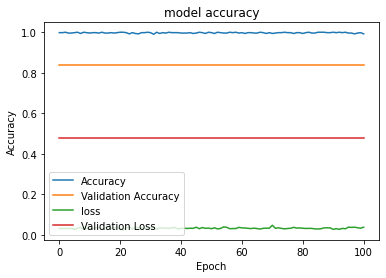

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
model_json_final = model.to_json()
with open("/content/drive/My Drive/MLOPS-FACE_RECOGNITION/face_recog.json", "w") as json_file:
    json_file.write(model_json_final)


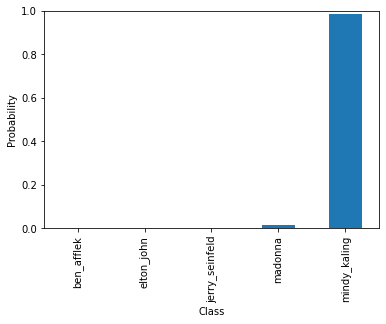

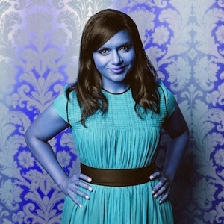

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt

X_val_sample, _ = next(validation_generator)
y_pred = model.predict(X_val_sample)

nb_sample = 1
for x, y in zip(X_val_sample[:nb_sample], y_pred[:nb_sample]):
    s = pd.Series({'ben_afflek': y[0], 'elton_john': y[1],'jerry_seinfeld': y[2],'madonna': y[3],'mindy_kaling': y[4]})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

    img = array_to_img(x)
    display(img)

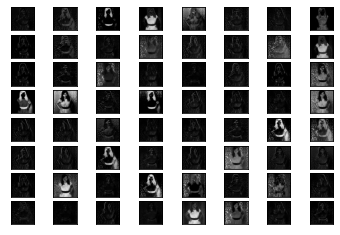

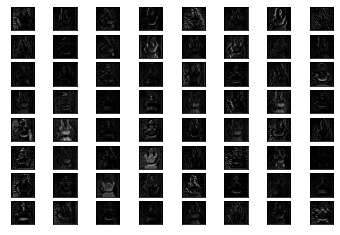

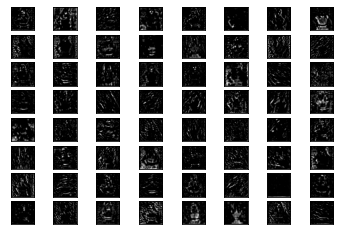

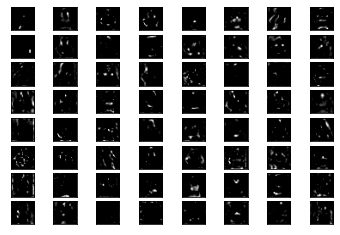

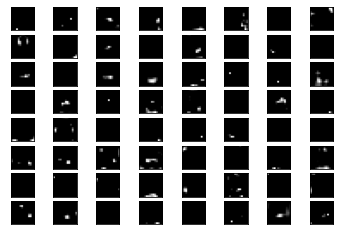

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
model = VGG16()
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
img = load_img('/content/drive/My Drive/MLOPS-FACE_RECOGNITION/data/val/mindy_kaling/httpcdnpastemagazinecomwwwarticlesmindykalingndbookjpg.jpg', target_size=(224, 224))
img = img_to_array(img)
img = expand_dims(img, axis=0)
img = preprocess_input(img)
feature_maps = model.predict(img)
square = 8
for fmap in feature_maps:
	ix = 1
	for _ in range(square):
		for _ in range(square):
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	pyplot.show()